In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = True

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/CDV/')

Mounted at /content/drive


In [6]:
print(os.getcwd())

/content/drive/MyDrive/Github/MLROM/CDV


In [7]:
from tools.misc_tools import create_CDV_data, create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_cdv, plot_latent_states_cdv, readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v3 import Autoencoder
from tools.GRU_SingleStep_v4 import RNN_GRU

In [8]:
# behaviour = 'initialiseAndTrainFromScratch'
behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[]


In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU')]
2.9.2


# CDV System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # making RNN save directory
    dir_name_rnn = os.getcwd() + dir_sep + 'saved_rnn'
    if not os.path.isdir(dir_name_rnn):
        os.makedirs(dir_name_rnn)

    counter = 0
    while True:
        dir_check = 'rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_rnn = dir_name_rnn + dir_sep + dir_check
    os.makedirs(dir_name_rnn)
    os.makedirs(dir_name_rnn+dir_sep+'plots')

    # autoencoder directory
    ae_idx = '001'
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx

    # reading simulation parameters
    with open(dir_name_ae + dir_sep + 'sim_data_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    params_mat = params_dict['params_mat']

    init_state = params_dict['init_state']

    t0 = params_dict['t0']
    T = params_dict['T']
    delta_t = params_dict['delta_t']

    return_params_arr = params_dict['return_params_arr']
    normalize_flag = params_dict['normalize_flag']
else:
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_009'

    # reading simulation parameters
    with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    dir_name_ae = params_dict['dir_name_ae']
    ae_idx = dir_name_ae[-3:]
    dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

    params_mat = params_dict['params_mat']

    init_state = params_dict['init_state']

    t0 = params_dict['t0']
    T = params_dict['T']
    delta_t = params_dict['delta_t']

    return_params_arr = params_dict['return_params_arr']
    normalize_flag = params_dict['normalize_flag']

    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    T_sample_input = params_rnn_dict['T_sample_input']
    T_sample_output = params_rnn_dict['T_sample_output']
    T_offset = params_rnn_dict['T_offset']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in RNN_specific_data, set to False.")
        normalize_dataset = False

In [13]:
# overriding T from autoencoder params
T = 1000

In [14]:
res_dict = create_CDV_data(
    T, t0, delta_t,
    params_mat,
    init_state, return_params_arr=return_params_arr,
    normalize=normalize_flag
)

all_data = res_dict['all_data']
N = res_dict['N']
boundary_idx_arr = res_dict['boundary_idx_arr']

if return_params_arr == True:
    params_arr = res_dict['params_arr']

if normalize_flag == True:
    normalization_constant_arr = res_dict['normalization_constant_arr']

In [15]:
n = len(boundary_idx_arr)

# Autoencoder

In [16]:
# from tools.ae_v3 import Autoencoder

In [17]:
# load_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_class_dict.txt'
# wt_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_ae_weights.h5'

# if colab_flag == False:
#     dir_name_ae_og = dir_name_ae
#     dir_name_ae_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_'+ae_idx
#     dir_name_ae = dir_name_ae_temp

load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

# if colab_flag == False:
#     dir_name_ae = dir_name_ae_og

In [18]:
ae_net = Autoencoder(12, load_file=load_file)
ae_net.load_weights_from_file(wt_file)

In [19]:
# create data
latent_states_all = ae_net.encoder_net.predict(all_data)
num_latent_states = latent_states_all.shape[1]

3126/3126 [==============================] - 5s 1ms/step


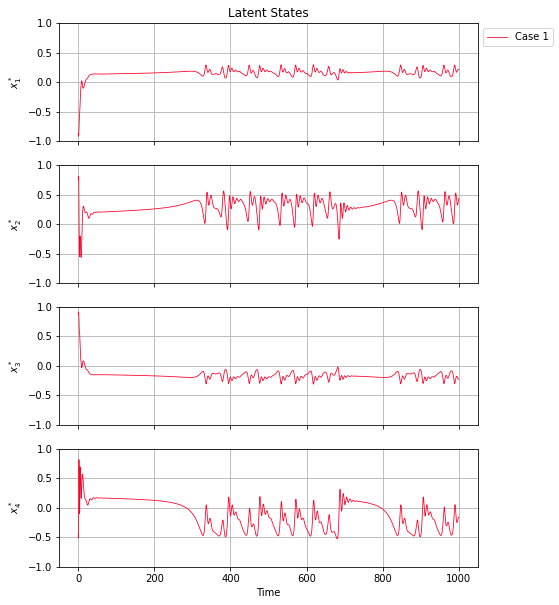

In [20]:
fig, ax = plot_latent_states_cdv(
    boundary_idx_arr,
    latent_states_all,
    all_data,
    delta_t,
    params_mat,
    # xlim=[-1,1],
    ylim=[-1,1],
    cmap_name='gist_rainbow',
    legend_markerscale=10,
    legend_bbox_to_anchor=[1,1],
    save_config_path=None
)

In [21]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# GRU

In [22]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    dt_rnn = 0.1
    T_sample_input = 90
    T_sample_output = 90
    T_offset = dt_rnn
    normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
    if return_params_arr != False:
        params = params_arr
    else:
        params = None

    # saving simulation data
    sim_data = {
        'params_mat':params_mat,
        'init_state':init_state,
        't0':t0,
        'T':T,
        'delta_t':delta_t,
        'return_params_arr':return_params_arr,
        'dir_name_ae':dir_name_ae,
        'normalize_flag':normalize_flag,
    }


    with open(dir_name_rnn+dir_sep+'sim_data_AE_params.txt', 'w') as f:
        f.write(str(sim_data))
        
    # saving RNN specific data
    RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'N':N,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
    }

    with open(dir_name_rnn+dir_sep+'RNN_specific_data.txt', 'w') as f:
        f.write(str(RNN_specific_data))

In [23]:
# cutting off initial transient
initial_t0 = np.array([400])
initial_idx = np.zeros_like(initial_t0)

begin_idx = 0
len_relevant_idx = 0
for i in range(len(initial_t0)):
    init_idx = (initial_t0[i] + 0.25*delta_t)//delta_t
    initial_idx[i] = init_idx + begin_idx
    begin_idx = boundary_idx_arr[i]
    len_relevant_idx += begin_idx - initial_idx[i]

relevant_idx = np.empty(shape=len_relevant_idx, dtype=np.int32)
start = 0
for i in range(len(initial_t0)):
    end = start + (boundary_idx_arr[i] - initial_idx[i])
    relevant_idx[start:end] = np.arange(initial_idx[i], boundary_idx_arr[i])
    start = end

In [24]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all[relevant_idx],
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    N,
    boundary_idx_arr-initial_idx,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']

In [25]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_dict = {
        'eta_begin':0.0001,
        'eta_high':0.001,
        'eta_low':0.00001
    }
    epochs = 200
    patience = 20  # parameter for early stopping
    min_delta = 5e-6  # parameter for early stopping
    lambda_reg = 1e-4  # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 64

    # saving training params
    training_specific_params = {
        'learning_rate_dict':learning_rate_dict,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size
    }

    with open(dir_name_rnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
else:
    # dir_name_rnn_og = dir_name_rnn
    # dir_name_rnn_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_rnn/rnn_'+dir_name_rnn_og[-3:]
    # dir_name_rnn = dir_name_rnn_temp

    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()


    tparams_dict = eval(''.join(lines))

    learning_rate_dict = tparams_dict['learning_rate_dict']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [26]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [27]:
idx = np.arange(num_samples)
# np.random.shuffle(idx)
boundary = int(np.round(
    (1-test_split) * num_samples
))

# defining shapes
training_input_shape = [boundary*len(boundary_idx_arr)]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [boundary*len(boundary_idx_arr)]
training_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [(num_samples-boundary)*len(boundary_idx_arr)]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [(num_samples-boundary)*len(boundary_idx_arr)]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape)
training_data_rnn_output = np.empty(shape=training_output_shape)

testing_data_rnn_input = np.empty(shape=testing_input_shape)
testing_data_rnn_output = np.empty(shape=testing_output_shape)

for i in range(len(boundary_idx_arr)):
    np.random.shuffle(idx)

    training_data_rnn_input[i*boundary:(i+1)*boundary] = data_rnn_input[i*num_samples + idx[0:boundary]]
    training_data_rnn_output[i*boundary:(i+1)*boundary] = data_rnn_output[i*num_samples + idx[0:boundary]]

    testing_data_rnn_input[i*(num_samples-boundary):(i+1)*(num_samples-boundary)] = data_rnn_input[i*num_samples + idx[boundary:]]
    testing_data_rnn_output[i*(num_samples-boundary):(i+1)*(num_samples-boundary)] = data_rnn_output[i*num_samples + idx[boundary:]]

# further shuffling
idx = np.arange(0, training_data_rnn_input.shape[0])
np.random.shuffle(idx)
training_data_rnn_input = training_data_rnn_input[idx]
training_data_rnn_output = training_data_rnn_output[idx]

idx = np.arange(0, testing_data_rnn_input.shape[0])
np.random.shuffle(idx)
testing_data_rnn_input = testing_data_rnn_input[idx]
testing_data_rnn_output = testing_data_rnn_output[idx]

In [28]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    rnn_layers_units = [2**6]*1
    stddev = 1e-4
    if return_params_arr != False:
        data_dim = num_latent_states + 6
    else:
        data_dim = num_latent_states

    if strategy is not None:
        with strtegy.scope():
            rnn_net = RNN_GRU(
                data_dim=data_dim,
            #     in_steps=int(T_sample_input // dt_rnn),
            #     out_steps=int(T_sample_output // dt_rnn),
                dt_rnn=dt_rnn,
                lambda_reg=lambda_reg,
                reg_name='L2',
                rnn_layers_units=rnn_layers_units,
                dense_layer_act_func='linear',
                load_file=None,
                # T_input=T_sample_input,
                # T_output=T_sample_output,
                stddev=stddev,
            )
    else:
        rnn_net = RNN_GRU(
            data_dim=data_dim,
        #     in_steps=int(T_sample_input // dt_rnn),
        #     out_steps=int(T_sample_output // dt_rnn),
            dt_rnn=dt_rnn,
            lambda_reg=lambda_reg,
            reg_name='L2',
            rnn_layers_units=rnn_layers_units,
            dense_layer_act_func='linear',
            load_file=None,
            # T_input=T_sample_input,
            # T_output=T_sample_output,
            stddev=stddev,
        )
    save_path = dir_name_rnn+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    rnn_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                load_file=load_file,
                # T_input=T_sample_input,
                # T_output=T_sample_output
            )
    else:
        rnn_net = RNN_GRU(
            load_file=load_file,
            # T_input=T_sample_input,
            # T_output=T_sample_output
        )
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_rnn+dir_sep+'checkpoints')
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'final_net_gru_weights.h5'
        # wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'f2'#+dir_sep+'saved_model.pb'
        rnn_net.load_weights_from_file(wt_file)
    
    # this forces the model to initialize its kernel weights/biases
    # temp = rnn_net.predict(tf.ones(shape=[batch_size, int(T_sample_input//dt_rnn), rnn_net.data_dim]))
    # this loads just the kernel wieghts and biases of the model
    # rnn_net.load_weights_from_file(wt_file)

    # rnn_net = tf.keras.models.load_model(wt_file)

1/1 [==============================] - 1s 845ms/step


In [29]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs)*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs)*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
    earlystopping_wait = 0
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt, earlystopping_wait = readAndReturnLossHistories(
        dir_name_ae=dir_name_rnn,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=[0],
        return_earlystopping_wait=True)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [30]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_dict['eta_begin']),
    loss=losses.MeanSquaredError(),
    run_eagerly=False
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            rnn_net.load_weights(wt_file)
    else:
        rnn_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    baseline = None
    if behaviour == 'loadCheckpointAndContinueTraining':
        baseline = np.min(val_loss_hist)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta,
        baseline=baseline
    )
    # the below two lines are useless because wait is set to 0 in on_train_begin
    # early_stopping_cb.wait = earlystopping_wait
    # print('early_stopping_cb.wait : {}\n'.format(early_stopping_cb.wait))

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_rnn+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        initial_value_threshold=baseline,
        period=1  # saves every 5 epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)
    
    # sigmoid annealing lr schedule
    lrschedule_cb = sigmoidWarmupAndDecayLRSchedule(
        eta_begin=learning_rate_dict['eta_begin'],
        eta_high=learning_rate_dict['eta_high'],
        eta_low=learning_rate_dict['eta_low'],
        warmup=20,
        expected_epochs=50,
        g_star=0.999,
        f_star=0.001
    )

    # training the network
    savelosses_cb.update_offset(epochs - num_epochs_left)
    
    history = rnn_net.fit(training_data_rnn_input, training_data_rnn_output,
        epochs=num_epochs_left,
        batch_size=batch_size,
        validation_split=val_split/(train_split+val_split),
        callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb, lrschedule_cb],
        verbose=1
    )

    val_loss_hist.extend(history.history['val_loss'])
    train_loss_hist.extend(history.history['loss'])

Epoch 1/152
638/638 [==============================] - ETA: 0s - loss: 4.1176e-04 - tot_time: 0h 10m 42.1s

Epoch 1: val_loss improved from 0.00041 to 0.00041, saving model to /content/drive/MyDrive/Github/MLROM/CDV/saved_rnn/rnn_009/checkpoints/checkpoint
 - saving loss histories at /content/drive/MyDrive/Github/MLROM/CDV/saved_rnn/rnn_009/checkpoints/LossHistoriesCheckpoint
638/638 [==============================] - 642s 587ms/step - loss: 4.1176e-04 - val_loss: 4.1157e-04
Epoch 2/152
638/638 [==============================] - ETA: 0s - loss: 4.0979e-04 - tot_time: 0h 16m 7.0s

Epoch 2: val_loss improved from 0.00041 to 0.00041, saving model to /content/drive/MyDrive/Github/MLROM/CDV/saved_rnn/rnn_009/checkpoints/checkpoint
 - saving loss histories at /content/drive/MyDrive/Github/MLROM/CDV/saved_rnn/rnn_009/checkpoints/LossHistoriesCheckpoint
638/638 [==============================] - 325s 509ms/step - loss: 4.0979e-04 - val_loss: 4.1107e-04
Epoch 3/152
638/638 [====================

In [31]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    test_loss = rnn_net.evaluate(
        testing_data_rnn_input, testing_data_rnn_output,
    )

    save_path = dir_name_rnn+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'lr_change':lr_change,
            'test_loss':test_loss
        }))
        
    if normalize_dataset == True:
        with open(save_path+dir_sep+'rnn_normalization.txt', 'w') as f:
            f.write(str({
                'normalization_arr':normalization_arr
            }))

    rnn_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

160/160 [==============================] - 21s 129ms/step - loss: 3.9956e-04


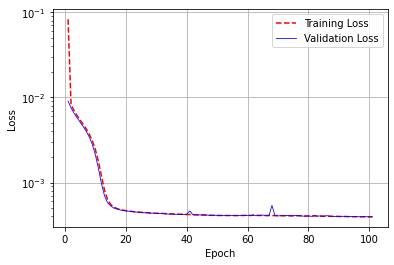

In [32]:
# plotting losses

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=None
)

plt.savefig(dir_name_rnn+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


data_idx : 136
1/1 [==============================] - 22s 22s/step


Text(0.5, 1.0, 'Latent States')

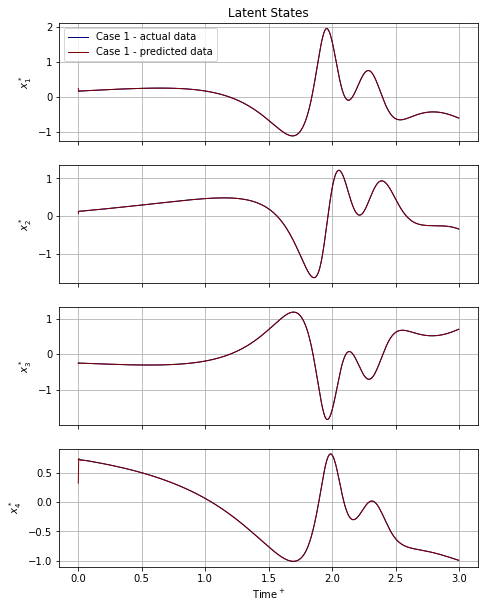

In [33]:
# data_type = 'training'
data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 3788
print('data_idx : {}'.format(data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])

n = 1
num_latent_states = data_out.shape[-1]
N = data_out.shape[0]

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = ['$x^*_1$', '$x^*_2$', '$x^*_3$', '$x^*_4$', '$x^*_5$', '$x^*_6$']

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]
input_time = np.arange(0, N)*dt_rnn/30

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

mpl_ax_artist_list = []
for j in range(num_latent_states):
    for i in range(n):
        obj_in = ax[j].plot(input_time, data_out[:, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        obj_out = ax[j].plot(input_time, prediction[0, :, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
        mpl_ax_artist_list.append(obj_in[0])
        mpl_ax_artist_list.append(obj_out[0])
    ax[j].set_ylabel(ax_ylabels[j])
    # if xlim is not None:
    #     ax[j].set_xlim(xlim)
    # if ylim is not None:
    #     ax[j].set_ylim(ylim)
    ax[j].grid(True)
    ax[j].set_axisbelow(True)


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
# plt.figlegend(
#     handles=mpl_ax_artist_list[0:n],
#     # bbox_to_anchor=[1.1,0.85],
#     loc=legend_loc,
#     bbox_to_anchor=legend_bbox_to_anchor,
#     ncol=ncols,
#     markerscale=legend_markerscale
# )
ax[0].legend(
    # handles=mpl_ax_artist_list[0:n],
    # bbox_to_anchor=[1.1,0.85],
    loc='best',
    # bbox_to_anchor=legend_bbox_to_anchor,
    ncol=ncols,
    # markerscale=legend_markerscale
)
# fig.suptitle(r'Latent States', size=12)
ax[0].set_title(r'Latent States', size=12)
# plt.savefig('AR-GRU.png', dpi=300, bbox_inches='tight')

In [34]:
# prediction.shape
testing_data_rnn_input[data_idx:data_idx+1, :, :].shape

(1, 900, 4)